In [36]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from sklearn.neighbors import KNeighborsClassifier
import re
import traceback

# Mount Google Drive (uncomment when using Colab)
# from google.colab import drive
# drive.mount('/content/drive')
filename_to_plate = {}
# 📌 1. Load CSV of ground truth plate labels with better error handling
def load_ground_truth(csv_path):
    """Load ground truth labels with proper error handling"""
    try:
        if not os.path.exists(csv_path):
            print(f"Ground truth file not found: {csv_path}")
            return pd.DataFrame()

        # Try different encodings for Bengali text
        for encoding in ['utf-8', 'utf-16', 'cp1252']:
            try:
                labels_df = pd.read_csv(csv_path, encoding=encoding)
                print(f"Labels loaded successfully with {encoding} encoding:")
                print(f"Columns: {labels_df.columns.tolist()}")
                print(f"Sample data:\n{labels_df.head()}")
                print(f"Total labels: {len(labels_df)}")

                for row,item in labels_df.iterrows():
                    #filename_to_plate[item['filename']] = item['plate_text']
                    filename_to_plate[item['filename']] = item['plate_text']
                    #print(filename_to_plate)
                print(filename_to_plate);

                return labels_df
            except UnicodeDecodeError:
                continue

        print("Failed to load CSV with any encoding")
        return pd.DataFrame()

    except Exception as e:
        print(f"Error loading labels: {e}")
        traceback.print_exc()
        return pd.DataFrame()

# Load labels
labels_df = load_ground_truth('/content/drive/MyDrive/datasets/train-test-25/grouth_truth.csv')

Labels loaded successfully with utf-8 encoding:
Columns: ['filename', 'plate_text']
Sample data:
                                            filename              plate_text
0                             Vehicle1730-Copy-2.png  চট্রো-মেট্রো-গ-১২-৭৫৯৪
1                               Vehicle1730-Copy.png  চট্রো-মেট্রো-গ-১১-৭২৮৮
2  142-jpg_jpg.rf.e7fae8cca7340adb313f50979206c0a...   ঢাকা-মেট্রো-চ-১৫-৮৪৯৯
3  149-jpg_jpg.rf.22a9c2b08b8fff7da45b7d5c7d3bf13...   ঢাকা-মেট্রো-গ-৮৫-০৩০১
4     88_jpg.rf.49fd3c5d661e93d3065e2d6dc5515952.png   ঢাকা-মেট্রো-গ-৩৯-৫০০৩
Total labels: 10
{'Vehicle1730-Copy-2.png': 'চট্রো-মেট্রো-গ-১২-৭৫৯৪', 'Vehicle1730-Copy.png': 'চট্রো-মেট্রো-গ-১১-৭২৮৮', '142-jpg_jpg.rf.e7fae8cca7340adb313f50979206c0a8.png': 'ঢাকা-মেট্রো-চ-১৫-৮৪৯৯', '149-jpg_jpg.rf.22a9c2b08b8fff7da45b7d5c7d3bf13d.png': 'ঢাকা-মেট্রো-গ-৮৫-০৩০১', '88_jpg.rf.49fd3c5d661e93d3065e2d6dc5515952.png': 'ঢাকা-মেট্রো-গ-৩৯-৫০০৩', 'Vehicle1315.jpg': 'ঢাকা-মেট্রো-ঘ-১৩-৪৫১১', 'Vehicle1353.jpg': 'ঢাকা-মেট্রো-ভ-১১-১৫৯৬'

In [37]:
# 📌 2. Improved plate region extraction with better error handling
def extract_plate_region(image):
    """Extract license plate region using morphological operations and edge detection"""
    try:
        if image is None:
            print("Input image is None")
            return None

        # Check if image is valid
        if len(image.shape) < 2:
            print("Invalid image dimensions")
            return None

        # Convert to grayscale - handle both color and grayscale images
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Morphological operations (erosion and dilation as per paper)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

        # Erosion followed by dilation
        eroded = cv2.erode(blurred, kernel, iterations=1)
        dilated = cv2.dilate(eroded, kernel, iterations=1)

        # Subtract processed image from original grayscale
        diff = cv2.absdiff(gray, dilated)

        # Apply threshold to create binary image
        _, binary1 = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Sobel edge detection on blurred image
        sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

        # Calculate gradient magnitude
        sobel_combined = np.sqrt(sobelx**2 + sobely**2)
        sobel_combined = cv2.convertScaleAbs(sobel_combined)

        # Create binary image from edges
        _, binary2 = cv2.threshold(sobel_combined, 50, 255, cv2.THRESH_BINARY)

        # Subtract edge image from morphological result
        final_binary = cv2.absdiff(binary1, binary2)

        # Find contours
        contours, _ = cv2.findContours(final_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found")
            return None

        # Filter contours based on area and aspect ratio
        plate_candidates = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = cv2.contourArea(cnt)

            # Avoid division by zero
            if h == 0:
                continue

            aspect_ratio = w / float(h)

            # Adjusted thresholds - more lenient for initial testing
            if area > 300 and 1.5 < aspect_ratio < 8.0:
                plate_candidates.append((cnt, area, x, y, w, h))

        # Sort by area and return the largest valid candidate
        if plate_candidates:
            plate_candidates.sort(key=lambda x: x[1], reverse=True)
            _, _, x, y, w, h = plate_candidates[0]

            # Add bounds checking
            height, width = image.shape[:2]
            x = max(0, x)
            y = max(0, y)
            w = min(w, width - x)
            h = min(h, height - y)

            extracted_plate = image[y:y+h, x:x+w]

            # Check if extracted region is valid
            if extracted_plate.size == 0:
                print("Extracted plate region is empty")
                return None

            return extracted_plate

        print("No valid plate candidates found")
        return None

    except Exception as e:
        print(f"Error in plate extraction: {e}")
        traceback.print_exc()
        return None


In [38]:
# 📌 3. Determine plate color with better error handling
def is_green_plate(plate_img):
    """Determine if plate is green (commercial) or white (private)"""
    try:
        if plate_img is None or plate_img.size == 0:
            return False

        # Handle grayscale images
        if len(plate_img.shape) == 2:
            # Convert grayscale to BGR for color detection
            plate_img = cv2.cvtColor(plate_img, cv2.COLOR_GRAY2BGR)

        # Convert to HSV for better color detection
        hsv = cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV)

        # Define range for green color in HSV
        lower_green = np.array([40, 50, 50])
        upper_green = np.array([80, 255, 255])

        # Create mask for green pixels
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        total_pixels = plate_img.shape[0] * plate_img.shape[1]

        if total_pixels == 0:
            return False

        green_ratio = np.sum(green_mask > 0) / total_pixels

        return green_ratio > 0.3  # If more than 30% green pixels

    except Exception as e:
        print(f"Error in color detection: {e}")
        return False


In [39]:
# 📌 4. Improved plate line segmentation with better error handling
def segment_plate_lines(plate_img):
    """Segment plate into top and bottom lines"""
    try:
        if plate_img is None or plate_img.size == 0:
            return None, None

        # Get image dimensions
        if len(plate_img.shape) == 3:
            h, w, _ = plate_img.shape
        else:
            h, w = plate_img.shape

        # Crop borders as per paper (5% top, 1.25% sides)
        top_crop = max(1, int(0.05 * h))
        side_crop = max(1, int(0.0125 * w))

        # Ensure crops don't exceed image dimensions
        top_crop = min(top_crop, h // 4)
        side_crop = min(side_crop, w // 8)

        # Apply cropping with bounds checking
        y_start = top_crop
        y_end = max(y_start + 1, h - side_crop)
        x_start = side_crop
        x_end = max(x_start + 1, w - side_crop)

        cropped = plate_img[y_start:y_end, x_start:x_end]

        if cropped.size == 0:
            print("Cropped image is empty")
            return None, None

        # Convert to grayscale if needed
        if len(cropped.shape) == 3:
            gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        else:
            gray = cropped.copy()

        # Apply adaptive threshold for better results
        binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)

        # Split into top and bottom halves
        h_bin = binary.shape[0]
        if h_bin < 2:
            print("Binary image too small to split")
            return None, None

        split_point = h_bin // 2

        top_line = binary[:split_point, :]
        bottom_line = binary[split_point:, :]

        return top_line, bottom_line

    except Exception as e:
        print(f"Error in line segmentation: {e}")
        traceback.print_exc()
        return None, None

In [40]:

# 📌 5. Enhanced character segmentation with better error handling
def segment_characters(line_img, expected_count=None):
    """Segment individual characters from a line"""
    try:
        if line_img is None or line_img.size == 0:
            return []

        # Apply morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(line_img, cv2.MORPH_CLOSE, kernel)

        # Find contours
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return []

        # Filter and sort contours
        char_boxes = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            area = w * h

            # More lenient size filtering
            if area > 30 and w > 3 and h > 8:
                char_boxes.append((x, y, w, h))

        # Sort left to right
        char_boxes.sort(key=lambda box: box[0])

        # Handle merged characters if expected count is provided
        if expected_count and len(char_boxes) < expected_count:
            char_boxes = split_merged_characters(char_boxes, line_img, expected_count)

        # Extract character images with bounds checking
        char_images = []
        line_h, line_w = line_img.shape

        for x, y, w, h in char_boxes:
            # Ensure coordinates are within bounds
            x = max(0, min(x, line_w - 1))
            y = max(0, min(y, line_h - 1))
            w = max(1, min(w, line_w - x))
            h = max(1, min(h, line_h - y))

            char_img = line_img[y:y+h, x:x+w]

            if char_img.size > 0:
                char_images.append(char_img)

        return char_images

    except Exception as e:
        print(f"Error in character segmentation: {e}")
        traceback.print_exc()
        return []

def split_merged_characters(char_boxes, line_img, expected_count):
    """Split characters that may have merged together"""
    try:
        if not char_boxes:
            return char_boxes

        # Calculate median width
        widths = [w for _, _, w, _ in char_boxes]
        if not widths:
            return char_boxes

        median_width = np.median(widths)

        new_boxes = []
        for x, y, w, h in char_boxes:
            if w > 1.5 * median_width and median_width > 0:
                # Split wide character into two
                split_width = w // 2
                new_boxes.append((x, y, split_width, h))
                new_boxes.append((x + split_width, y, split_width, h))
            else:
                new_boxes.append((x, y, w, h))

        return sorted(new_boxes, key=lambda box: box[0])

    except Exception as e:
        print(f"Error splitting merged characters: {e}")
        return char_boxes

In [41]:


# 📌 6. Improved training data loading with better error handling
def load_training_data(folder_path):
    """Load training data for character recognition"""
    X, y = [], []

    if not os.path.exists(folder_path):
        print(f"Training folder not found: {folder_path}")
        return np.array([]), np.array([])

    try:
        files = os.listdir(folder_path)
        print(f"Found {len(files)} files in training folder")
    except Exception as e:
        print(f"Error reading training folder: {e}")
        return np.array([]), np.array([])

    successful_loads = 0

    for file in files:
        try:
            # Skip non-image files
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue

            # Extract label from filename - try different patterns
            label = None

            label = filename_to_plate.get(file)

            # # Pattern 1: label_something.ext
            # if '_' in file:
            #     label = file.split('_')[0]
            # # Pattern 2: label-something.ext
            # elif '-' in file:
            #     label = file.split('-')[0]
            # # Pattern 3: just the filename without extension
            # else:
            #     label = os.path.splitext(file)[0]

            if not label:
                continue

            # Load and process image
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None and img.size > 0:
                # Resize to 32x32 and flatten
                img_resized = cv2.resize(img, (32, 32))
                img_flattened = img_resized.flatten()

                # Ensure we have the right number of features
                if len(img_flattened) == 1024:
                    X.append(img_flattened)
                    y.append(label)
                    successful_loads += 1

        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue

    print(f"Successfully loaded {successful_loads} training images")
    if successful_loads > 0:
        print(f"Sample labels: {list(set(y))[:10]}")  # Show first 10 unique labels

    return np.array(X), np.array(y)

# Load training data
print("Loading training data...")
X_train, y_train = load_training_data("/content/drive/MyDrive/datasets/train-test-25/train")

# Train KNN model with better error handling
knn = None
if len(X_train) > 0:
    try:
        print(f"Training KNN with {len(X_train)} samples...")
        knn = KNeighborsClassifier(n_neighbors=min(3, len(X_train)))  # Ensure k <= n_samples
        knn.fit(X_train, y_train)
        print("KNN model trained successfully")
        print(f"Number of unique labels: {len(np.unique(y_train))}")
        print(f"Sample unique labels: {np.unique(y_train)[:10]}")
    except Exception as e:
        print(f"Error training KNN: {e}")
        traceback.print_exc()
        knn = None
else:
    print("Error: No training data loaded. Cannot train KNN model.")

Loading training data...
Found 10 files in training folder
Successfully loaded 10 training images
Sample labels: ['ঢাকা-মেট্রো-গ-৩৯-১৭৮৬', 'ঢাকা-মেট্রো-চ-১৫-৮৪৯৯', 'ঢাকা-মেট্রো-ঘ-১৩-৪৫১১', 'ঢাকা-মেট্রো-গ-১৫-০৫৬৮', 'চট্রো-মেট্রো-গ-১১-৭২৮৮', 'চট্রো-মেট্রো-গ-১২-৭৫৯৪', 'ঢাকা-মেট্রো-গ-৩৯-৫০০৩', 'ঢাকা-মেট্রো-ভ-১১-১৫৯৬', 'ঢাকা-মেট্রো-গ-২১-৬০১৭', 'ঢাকা-মেট্রো-গ-৮৫-০৩০১']
Training KNN with 10 samples...
KNN model trained successfully
Number of unique labels: 10
Sample unique labels: ['চট্রো-মেট্রো-গ-১১-৭২৮৮' 'চট্রো-মেট্রো-গ-১২-৭৫৯৪' 'ঢাকা-মেট্রো-গ-১৫-০৫৬৮'
 'ঢাকা-মেট্রো-গ-২১-৬০১৭' 'ঢাকা-মেট্রো-গ-৩৯-১৭৮৬' 'ঢাকা-মেট্রো-গ-৩৯-৫০০৩'
 'ঢাকা-মেট্রো-গ-৮৫-০৩০১' 'ঢাকা-মেট্রো-ঘ-১৩-৪৫১১' 'ঢাকা-মেট্রো-চ-১৫-৮৪৯৯'
 'ঢাকা-মেট্রো-ভ-১১-১৫৯৬']


In [42]:

# 📌 7. Character recognition with better error handling
def recognize_characters(char_images, knn_model):
    """Recognize characters using trained KNN model"""
    if knn_model is None or len(char_images) == 0:
        return []

    predictions = []
    for i, char_img in enumerate(char_images):
        try:
            if char_img is None or char_img.size == 0:
                predictions.append("?")
                continue

            # Resize and flatten
            resized = cv2.resize(char_img, (32, 32))
            flattened = resized.flatten().reshape(1, -1)

            # Ensure correct feature count
            if flattened.shape[1] != 1024:
                print(f"Warning: Character {i} has {flattened.shape[1]} features, expected 1024")
                predictions.append("?")
                continue

            # Predict
            pred = knn_model.predict(flattened)[0]
            predictions.append(pred)

        except Exception as e:
            print(f"Error recognizing character {i}: {e}")
            predictions.append("?")

    return predictions

In [43]:
# 📌 8. Full pipeline with comprehensive error handling
def process_single_image(img_path, true_label=None, show_debug=False):
    """Process a single image through the entire pipeline"""
    try:
        print(f"Processing: {os.path.basename(img_path)}")

        # Load image
        if not os.path.exists(img_path):
            return None, f"Image file not found: {img_path}"

        img = cv2.imread(img_path)
        if img is None:
            return None, f"Could not load image: {img_path}"

        print(f"Image loaded: {img.shape}")

        if show_debug:
            plt.figure(figsize=(15, 10))
            plt.subplot(2, 4, 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title("Original Image")
            plt.axis('off')

        # Extract plate region
        print("Extracting plate region...")
        plate = extract_plate_region(img)
        if plate is None:
            return None, "No plate detected"

        print(f"Plate extracted: {plate.shape}")

        if show_debug:
            plt.subplot(2, 4, 2)
            if len(plate.shape) == 3:
                plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(plate, cmap='gray')
            plt.title("Extracted Plate")
            plt.axis('off')

        # Determine plate color
        is_green = is_green_plate(plate)
        plate_type = "Commercial (Green)" if is_green else "Private (White)"
        print(f"Plate type: {plate_type}")

        # Segment into lines
        print("Segmenting plate lines...")
        top_line, bottom_line = segment_plate_lines(plate)
        if top_line is None or bottom_line is None:
            return None, "Line segmentation failed"

        print(f"Lines segmented - Top: {top_line.shape}, Bottom: {bottom_line.shape}")

        if show_debug:
            plt.subplot(2, 4, 3)
            plt.imshow(top_line, cmap='gray')
            plt.title("Top Line")
            plt.axis('off')

            plt.subplot(2, 4, 4)
            plt.imshow(bottom_line, cmap='gray')
            plt.title("Bottom Line")
            plt.axis('off')

        # Segment characters
        print("Segmenting characters...")
        top_chars = segment_characters(top_line)
        bottom_chars = segment_characters(bottom_line, expected_count=6)

        print(f"Characters segmented - Top: {len(top_chars)}, Bottom: {len(bottom_chars)}")

        if show_debug and top_chars:
            # Display segmented characters
            for i, char in enumerate(top_chars[:4]):  # Show first 4
                if i + 5 <= 8:  # Ensure we don't exceed subplot count
                    plt.subplot(2, 4, 5 + i)
                    plt.imshow(char, cmap='gray')
                    plt.title(f"Top Char {i+1}")
                    plt.axis('off')

        # Recognize characters
        if knn is not None:
            print("Recognizing characters...")
            top_predictions = recognize_characters(top_chars, knn)
            bottom_predictions = recognize_characters(bottom_chars, knn)

            # Format result
            top_text = ''.join(top_predictions) if top_predictions else ""
            bottom_text = ''.join(bottom_predictions) if bottom_predictions else ""
            full_prediction = f"{top_text}-{bottom_text}"

            result = {
                'filename': os.path.basename(img_path),
                'plate_type': plate_type,
                'top_line': top_text,
                'bottom_line': bottom_text,
                'full_prediction': full_prediction,
                'true_label': true_label,
                'top_char_count': len(top_chars),
                'bottom_char_count': len(bottom_chars)
            }

            if show_debug:
                plt.tight_layout()
                plt.show()
                print(f"Result: {result}")

            return result, None
        else:
            return None, "KNN model not trained"

    except Exception as e:
        error_msg = f"Error processing {os.path.basename(img_path)}: {str(e)}"
        print(error_msg)
        traceback.print_exc()
        return None, error_msg


STARTING SYSTEM TEST

Testing with 10 images...

Processing image 1/10: Vehicle1366.png
Processing: Vehicle1366.png
Image loaded: (346, 440, 3)
Extracting plate region...
Plate extracted: (190, 380, 3)
Plate type: Private (White)
Segmenting plate lines...
Lines segmented - Top: (88, 372), Bottom: (89, 372)
Segmenting characters...
Characters segmented - Top: 8, Bottom: 9
Recognizing characters...


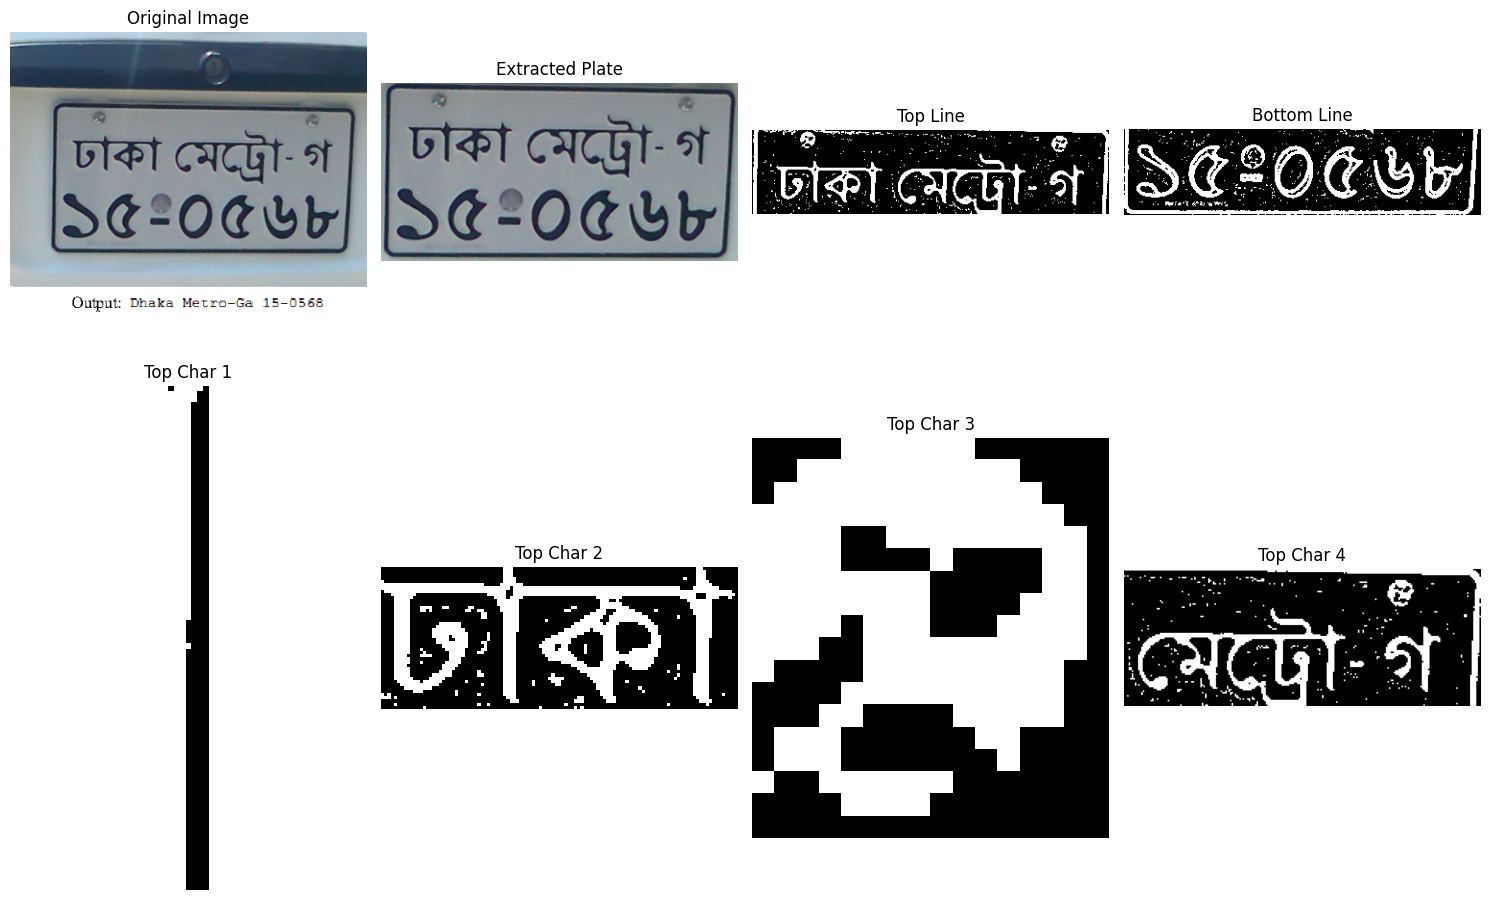

Result: {'filename': 'Vehicle1366.png', 'plate_type': 'Private (White)', 'top_line': 'ঢাকা-মেট্রো-গ-২১-৬০১৭ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-ঘ-১৩-৪৫১১ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-২১-৬০১৭ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-গ-৮৫-০৩০১', 'bottom_line': 'ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-ঘ-১৩-৪৫১১ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-২১-৬০১৭', 'full_prediction': 'ঢাকা-মেট্রো-গ-২১-৬০১৭ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-ঘ-১৩-৪৫১১ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-২১-৬০১৭ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-গ-৮৫-০৩০১-ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-ঘ-১৩-৪৫১১ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-১৫-০৫৬৮ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-৩৯-৫০০৩ঢাকা-মেট্রো-গ-২১-৬০১৭', 'true_label': 'ঢাকা-মেট্রো-গ-১৫-০৫৬৮', 'top_char_count': 8, 'bottom_char_count': 9}
✓ Success: ঢাকা-মেট্রো-গ-২১-৬০১৭ঢাকা-মেট্রো-গ-৮৫-০৩০১ঢাকা-মেট্রো-ঘ-১৩-

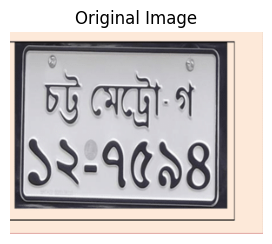

In [44]:

# 📌 9. Test with your images
def test_system(test_folder=None, num_images=10):
    """Test the system with specified images"""

    if test_folder is None:
        test_folder = "/content/drive/MyDrive/datasets/train-test-25/train"

    # Get image files
    if not os.path.exists(test_folder):
        print(f"Test folder not found: {test_folder}")
        return [], []

    try:
        image_files = [f for f in os.listdir(test_folder)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        image_files = image_files[:num_images]  # Limit to specified number
    except Exception as e:
        print(f"Error reading test folder: {e}")
        return [], []

    print(f"\nTesting with {len(image_files)} images...")

    results = []
    errors = []

    for i, img_file in enumerate(image_files):
        print(f"\n{'='*60}")
        print(f"Processing image {i+1}/{len(image_files)}: {img_file}")
        print(f"{'='*60}")

        img_path = os.path.join(test_folder, img_file)

        # Get ground truth if available
        true_label = None
        if not labels_df.empty:
            # Handle different possible column names
            filename_col = None
            label_col = None

            for col in labels_df.columns:
                if 'filename' in col.lower() or 'file' in col.lower():
                    filename_col = col
                if 'plate' in col.lower() or 'label' in col.lower() or 'text' in col.lower():
                    label_col = col

            if filename_col and label_col:
                matching_rows = labels_df[labels_df[filename_col] == img_file]
                if not matching_rows.empty:
                    true_label = matching_rows.iloc[0][label_col]

        # Process image
        result, error = process_single_image(img_path, true_label, show_debug=(i < 2))

        if result:
            results.append(result)
            print(f"✓ Success: {result['full_prediction']}")
            if true_label:
                print(f"Ground truth: {true_label}")
                print(f"Match: {result['full_prediction'] == true_label}")
        else:
            errors.append({'filename': img_file, 'error': error})
            print(f"✗ Failed: {error}")

    # Summary
    print(f"\n{'='*60}")
    print(f"TESTING SUMMARY")
    print(f"{'='*60}")
    print(f"Total images processed: {len(image_files)}")
    print(f"Successful extractions: {len(results)}")
    print(f"Failed extractions: {len(errors)}")
    print(f"Success rate: {len(results)/len(image_files)*100:.1f}%")

    if results:
        print(f"\nSuccessful Results:")
        for result in results:
            print(f"  {result['filename']}: {result['full_prediction']} ({result['plate_type']})")

    if errors:
        print(f"\nErrors:")
        for error in errors:
            print(f"  {error['filename']}: {error['error']}")

    return results, errors

# Run the test
print("\n" + "="*60)
print("STARTING SYSTEM TEST")
print("="*60)

if knn is not None:
    results, errors = test_system(num_images=10)
else:
    print("Cannot run test - KNN model not trained. Please check your training data path.")
    print("\nDebugging steps:")
    print("1. Check if the training folder path exists")
    print("2. Check if there are image files in the training folder")
    print("3. Check if the image filenames contain labels (e.g., 'ক_001.png')")
    print("4. Verify that the images can be loaded by OpenCV")